# SpecSim Fiberloss Calculations

Examples of using SpecSim to calculate fiberloss fractions. The plots produced below are for [DESI-doc-2720](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=2720).  The latest documentation for the SpecSim features used below is at [specsim.readthedocs.io](http://specsim.readthedocs.io/en/latest/fiberloss.html).

In order to run these examples, you will need to have [SpecSim installed](http://specsim.readthedocs.io/en/stable/install.html) and [$DESIMODEL set](http://specsim.readthedocs.io/en/stable/config.html#desi-configuration).  **You will also need to 
copy the YAML files in the `specsim/docs/nb/config/` folder to `specsim/data/config/`.**

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os.path

In [3]:
import astropy.table
import astropy.units as u

## Benchmark Timing Results

Use the `quickfiberloss` command-line script to benchmark with different galaxy profiles and number of pixels, e.g.
```
quickfiberloss -c desi -n 100 --num-pixels 16 --disk-fraction 0.0 --bulge-fraction 1.0
```

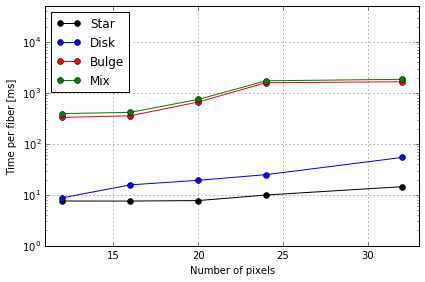

In [4]:
def plot_benchmarks(save=None):
    npix = np.array([12, 16, 20, 24, 32])
    star = np.array([7.568, 7.555, 7.720, 9.930, 14.459])
    disk = np.array([8.763, 15.712, 19.302, 24.909, 54.109])
    bulge = np.array([331.046, 356.791, 663.471, 1587.195, 1658.582])
    mix = np.array([393.705, 416.422, 746.005, 1733.116, 1850.975])
    plt.plot(npix, star, 'k-o', label='Star')
    plt.plot(npix, disk, 'b-o', label='Disk')
    plt.plot(npix, bulge, 'r-o', label='Bulge')
    plt.plot(npix, mix, 'g-o', label='Mix')
    plt.xlabel('Number of pixels')
    plt.ylabel('Time per fiber [ms]')
    plt.xlim(11, 33)
    plt.ylim(1, 5e4)
    plt.yscale('log')
    plt.grid()
    plt.legend(loc='upper left')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_benchmarks(save='benchmark.pdf')

## DesiModel Fiberloss

In [5]:
def get_desimodel_fiberloss(obj_type='lrg'):
    path = os.path.join(os.environ['DESIMODEL'], 'data', 'throughput',
                        'fiberloss-{0}.dat'.format(obj_type))
    t = astropy.table.Table.read(path, format='ascii', names=['wlen', 'accept'])
    return t

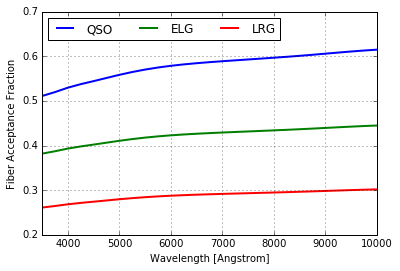

In [6]:
def plot_desimodel_fiberloss(save=None):
    
    for obj_type in ('qso', 'elg', 'lrg'):
        t = get_desimodel_fiberloss(obj_type)
        plt.plot(t['wlen'], t['accept'], lw=2, label=obj_type.upper())
    plt.legend(loc='upper left', ncol=3)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Fiber Acceptance Fraction')
    plt.ylim(0.2, 0.7)
    plt.xlim(3500, 10000)
    plt.grid()
    if save:
        plt.savefig(save)

plot_desimodel_fiberloss('desimodel-fiberloss.pdf')

## Fiberloss Results

Initialize a DESI simulator:

In [7]:
import specsim.simulator
import specsim.fiberloss

For fiberloss calculations with `GalSimFiberlossCalculator`, only the atmosphere and instrument config is used, and the source parameters are passed via args.  Initialize SpecSim to use GalSim with different instrument effects turned on.

In [8]:
desi_blur = specsim.simulator.Simulator('desi-blur')

In [9]:
desi_blur_offset = specsim.simulator.Simulator('desi-blur-offset')

In [10]:
desi_blur_offset_scale = specsim.simulator.Simulator('desi-blur-offset-scale')

In [11]:
desi_blur_offset_scale_stochastic = specsim.simulator.Simulator('desi-blur-offset-scale-stochastic')

The default corresponds to all effects included:

In [12]:
desi = desi_blur_offset_scale_stochastic

Initialize the wavelength grid where fiberloss will be tabulated:

In [13]:
def create_wlen_grid(num_wlen=11, desi=desi):
    wavelength = desi.simulated['wavelength']
    wlen_unit = wavelength.unit
    return np.linspace(wavelength.data[0], wavelength.data[-1], num_wlen) * wlen_unit

wlen_grid = create_wlen_grid()

Generate random fiber positions uniformly over the focal plane:

In [14]:
def generate_fiber_positions(nfiber=5000, seed=123, desi=desi):
    gen = np.random.RandomState(seed)
    focal_r = (
        np.sqrt(gen.uniform(size=nfiber)) * desi.instrument.field_radius)
    phi = 2 * np.pi * gen.uniform(size=nfiber)
    return np.cos(phi) * focal_r, np.sin(phi) * focal_r

focal_x, focal_y = generate_fiber_positions(500)

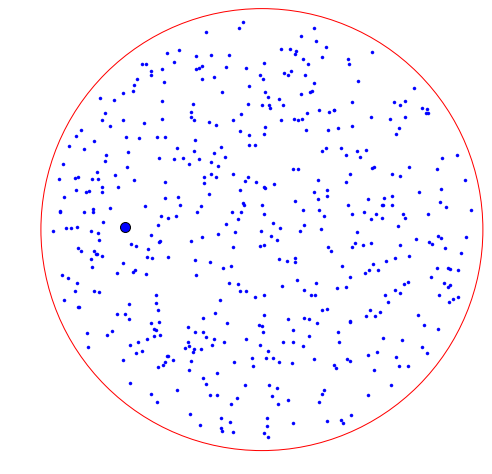

In [15]:
def plot_fiber_positions(save=None, desi=desi, select=None):
    plt.figure(figsize=(8, 8))
    x, y = focal_x.to(u.mm).value, focal_y.to(u.mm).value
    plt.plot(x, y, '.')
    if select is not None:
        plt.scatter(x[select], y[select], s=100)
    r = 1.05 * desi.instrument.field_radius.to(u.mm).value
    plt.xlim(-1.01 * r, +1.01 * r)
    plt.ylim(-1.01 * r, +1.01 * r)
    plt.gca().set_aspect('equal', 'datalim')
    plt.gca().add_artist(plt.Circle((0, 0), r, color='r', fill=False))
    plt.axis('off')
    if save:
        plt.savefig(save)
    
plot_fiber_positions(save='fibers.pdf', select=slice(5, 6))

In [16]:
one_x, one_y = focal_x[5:6], focal_y[5:6]

In [17]:
repeat_x = np.tile(focal_x[5].to(u.mm).value, [500]) * u.mm
repeat_y = np.tile(focal_y[5].to(u.mm).value, [500]) * u.mm

Initialize source profiles:

In [18]:
def generate_sources(nsrc=5000, disk_fraction=1., bulge_fraction=0., vary='', seed=123):
    gen = np.random.RandomState(seed)
    varied = vary.split(',')
    source_fraction = np.tile([disk_fraction, bulge_fraction], (nsrc, 1))
    source_half_light_radius = np.tile([0.45, 1.0], (nsrc, 1))
    source_minor_major_axis_ratio = np.tile([1.0, 1.0], (nsrc, 1))
    if 'pa' in varied:
        source_position_angle = 360. * gen.uniform(size=(nsrc, 2))
    else:
        source_position_angle = np.tile([30., 30.], (nsrc, 1))
    return source_fraction, source_half_light_radius, source_minor_major_axis_ratio, source_position_angle

In [19]:
qsos = generate_sources(500, 0., 0., seed=1)

In [20]:
elgs_round = generate_sources(500, 1., 0., seed=1)

In [21]:
lrgs_round = generate_sources(500, 0., 1., seed=1)

Perform fiberloss calculations:

In [22]:
calc = specsim.fiberloss.GalsimFiberlossCalculator(
    desi.instrument.fiber_diameter.to(u.um).value,
    wlen_grid.to(u.Angstrom).value,
    num_pixels=16, oversampling=32, moffat_beta=3.5)

In [23]:
def get_fiberloss(source_fraction, source_half_light_radius, source_minor_major_axis_ratio,
                  source_position_angle,
                  x=focal_x, y=focal_y, seeing=1.1*u.arcsec, desi=desi, calc=calc):
    # Subtract instrumental PSF.
    Jacoby = 0.219
    seeing = 2.35482 * np.sqrt((seeing.to(u.arcsec).value/2.35482) ** 2 - Jacoby**2) * u.arcsec
    # Tabulate seeing.
    desi.atmosphere.seeing['fwhm_ref'] = seeing
    seeing_fwhm = desi.atmosphere.get_seeing_fwhm(wlen_grid).to(u.arcsec).value
    # Calculate optics.
    scale, blur, offset = desi.instrument.get_focal_plane_optics(x, y, wlen_grid)
    # Do the fiberloss calculations.
    return calc.calculate(
        seeing_fwhm,
        scale.to(u.um / u.arcsec).value, offset.to(u.um).value,
        blur.to(u.um).value,
        source_fraction, source_half_light_radius,
        source_minor_major_axis_ratio, source_position_angle)

In [24]:
def plot_fiberloss(floss, cmap_name='viridis', alpha=0.1, ylim=(None, None),
                   desi=desi, desimodel_type=None, save=None, overlay=False):
    if not overlay:
        plt.figure(figsize=(5, 4))
    wlen = wlen_grid.value
    rvalues = np.sqrt(focal_x ** 2 + focal_y ** 2)
    norm = matplotlib.colors.Normalize(
        vmin=0., vmax=desi.instrument.field_radius.to(u.mm).value)
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(cmap_name))
    for f, r in zip(floss, rvalues):
        color = sm.to_rgba(r)
        p = plt.plot(wlen, f, ls='-', c=color, alpha=0.2)
    plt.plot(wlen, np.median(floss, axis=0), 'k-', lw=2, label='median')
    if desimodel_type:
        t = get_desimodel_fiberloss(desimodel_type)
        plt.plot(t['wlen'], t['accept'], 'r--', lw=2, label='desimodel')
    if not overlay:
        plt.ylim(*ylim)
        # Very useful trick from http://stackoverflow.com/posts/11558629/revisions
        sm._A = []
        plt.colorbar(sm).set_label('Radius [mm]')
        plt.xlabel('Wavelength [Angstrom]')
        plt.ylabel('Fiber accepetance fraction')
        plt.xlim(wlen[0], wlen[-1])
        plt.tight_layout()
    if save:
        plt.savefig(save)

Calculate the effects of adding each effect in turn to a sample of round ELGs:

In [25]:
f_elg_blur = get_fiberloss(*elgs_round, desi=desi_blur)

In [26]:
f_elg_blur_offset = get_fiberloss(*elgs_round, desi=desi_blur_offset)

In [27]:
f_elg_blur_offset_scale = get_fiberloss(*elgs_round, desi=desi_blur_offset_scale)

In [28]:
f_elg_blur_offset_scale_stochastic = get_fiberloss(*elgs_round, desi=desi_blur_offset_scale_stochastic)

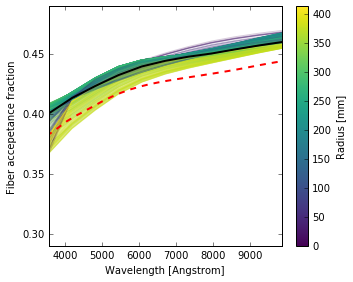

In [29]:
plot_fiberloss(f_elg_blur, ylim=(0.29, 0.49), desimodel_type='elg', save='elg_blur.png')

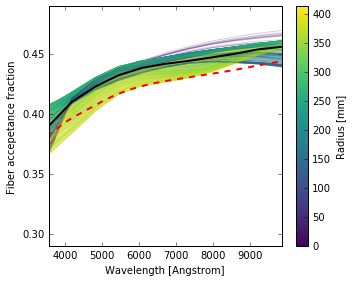

In [30]:
plot_fiberloss(f_elg_blur_offset, ylim=(0.29, 0.49), desimodel_type='elg', save='elg_offset.png')

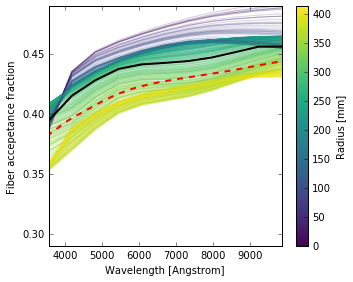

In [31]:
plot_fiberloss(f_elg_blur_offset_scale, ylim=(0.29, 0.49), desimodel_type='elg', save='elg_scale.png')

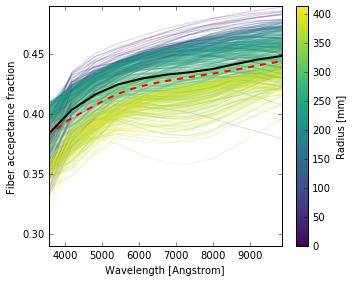

In [32]:
plot_fiberloss(f_elg_blur_offset_scale_stochastic, ylim=(0.29, 0.49), desimodel_type='elg', save='elg_stochastic.png')

Compare round ELGs with QSOs and round LRGs with all effects included:

In [33]:
f_qso = get_fiberloss(*qsos, desi=desi)

In [34]:
f_elg = f_elg_blur_offset_scale_stochastic

In [35]:
f_lrg = get_fiberloss(*lrgs_round, desi=desi)

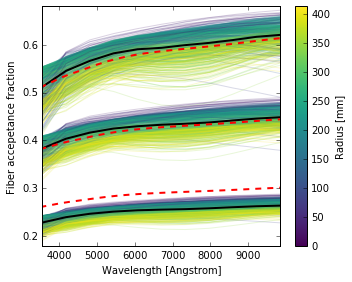

In [36]:
plot_fiberloss(f_qso, ylim=(0.18, 0.68), desimodel_type='qso')
plot_fiberloss(f_elg, desimodel_type='elg', overlay=True)
plot_fiberloss(f_lrg, desimodel_type='lrg', overlay=True, save='qso_elg_lrg.pdf')

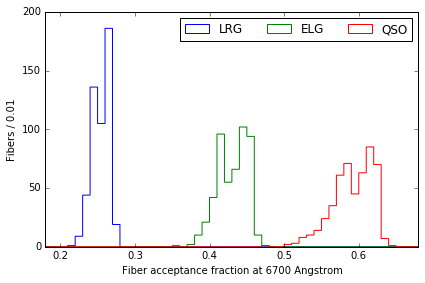

In [37]:
def slice_hist(wlen_index=5, floss = dict(LRG=f_lrg, QSO=f_qso, ELG=f_elg), save=None):
    wlen = wlen_grid[wlen_index]
    for t in ('LRG', 'ELG', 'QSO'):
        f = floss[t]
        plt.hist(f[:, wlen_index], histtype='step', label=t, range=(0.18,0.68), bins=50)
    plt.xlim(0.18, 0.68)
    plt.legend(ncol=3)
    plt.xlabel('Fiber acceptance fraction at {0:.0f}'.format(wlen))
    plt.ylabel('Fibers / 0.01')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
slice_hist(save='slices.pdf')

## Accuracy vs Resolution

In [38]:
calc12 = specsim.fiberloss.GalsimFiberlossCalculator(
    desi.instrument.fiber_diameter.to(u.um).value,
    wlen_grid.to(u.Angstrom).value,
    num_pixels=12, oversampling=32, moffat_beta=3.5)
calc16 = calc
calc20 = specsim.fiberloss.GalsimFiberlossCalculator(
    desi.instrument.fiber_diameter.to(u.um).value,
    wlen_grid.to(u.Angstrom).value,
    num_pixels=20, oversampling=32, moffat_beta=3.5)
calc24 = specsim.fiberloss.GalsimFiberlossCalculator(
    desi.instrument.fiber_diameter.to(u.um).value,
    wlen_grid.to(u.Angstrom).value,
    num_pixels=24, oversampling=32, moffat_beta=3.5)
calc32 = specsim.fiberloss.GalsimFiberlossCalculator(
    desi.instrument.fiber_diameter.to(u.um).value,
    wlen_grid.to(u.Angstrom).value,
    num_pixels=32, oversampling=32, moffat_beta=3.5)

In [39]:
elgs_one = generate_sources(1, 1., 0., seed=1)

In [40]:
f_elg_12 = get_fiberloss(*elgs_one, x=one_x, y=one_y, desi=desi, calc=calc12)
f_elg_16 = get_fiberloss(*elgs_one, x=one_x, y=one_y, desi=desi, calc=calc16)
f_elg_20 = get_fiberloss(*elgs_one, x=one_x, y=one_y, desi=desi, calc=calc20)
f_elg_24 = get_fiberloss(*elgs_one, x=one_x, y=one_y, desi=desi, calc=calc24)
f_elg_32 = get_fiberloss(*elgs_one, x=one_x, y=one_y, desi=desi, calc=calc32)

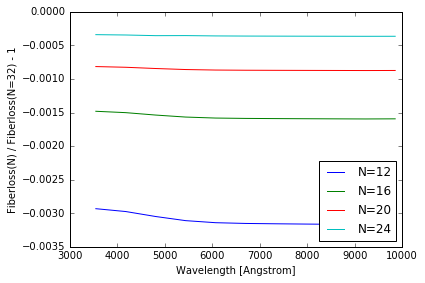

In [41]:
def plot_resolution(f={12: f_elg_12, 16: f_elg_16, 20: f_elg_20, 24: f_elg_24, 32: f_elg_32}, save=None):
    f0 = f_elg_32[0]
    for n in (12, 16, 20, 24,):
        plt.plot(wlen_grid, f[n][0] / f0 - 1, label='N={0:d}'.format(n))
    plt.legend(loc='lower right', ncol=1)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Fiberloss(N) / Fiberloss(N=32) - 1')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_resolution(save='resolution.pdf')

In [42]:
def generate_galaxy_sample(galaxy_type='ELG', n=500, save=None):
    
    if galaxy_type == 'ELG':
        frac = [1., 0.]
        hlr0, q0 = 0.45, 0.5
        xlim=(-0.8,1.6)
        ylim=(0,1.2)
    else:
        frac = [0., 1.]
        hlr0, q0 = 0.8, 0.6
        xlim = (-0.5,2.2)
        ylim = (0.2,1.1)
    
    d = np.random.normal(size=(2, n))
    hlr = hlr0 * np.exp(0.25 * d[0])
    q = q0 * np.exp(0.15 * d[1])
    q[q > 0.99] = 0.99

    frac = np.tile(frac, (n, 1))
    beta = 360. * np.random.uniform(size=(n, 2))
    
    plt.figure(figsize=(4, 4))
    plt.plot(hlr, q, '.')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xlabel('r [arcsec]')
    plt.ylabel('b / a')
    if save:
        plt.savefig(save)
        
    # Duplicate values to have disk+bulge values for each galaxy.
    hlr = np.tile(hlr, [2, 1]).T
    q = np.tile(q, [2, 1]).T
    
    return frac, hlr, q, beta

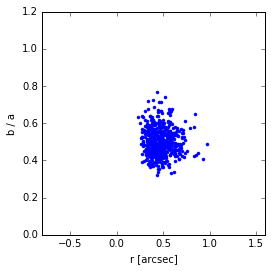

In [43]:
elg_sample = generate_galaxy_sample('ELG', 500,  save='elg-pop.png')

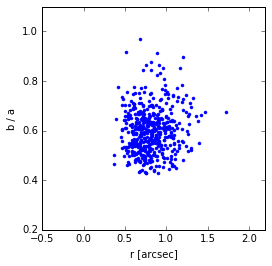

In [44]:
lrg_sample = generate_galaxy_sample('LRG', 500,  save='lrg-pop.png')

In [45]:
f_elg_sample = get_fiberloss(*elg_sample, x=repeat_x, y=repeat_y, desi=desi)

In [46]:
f_lrg_sample = get_fiberloss(*lrg_sample, x=repeat_x, y=repeat_y, desi=desi)

In [47]:
def plot_fiberloss_sample(floss, cmap_name='viridis', alpha=0.1, ylim=(None, None),
                          desimodel_type=None, save=None, zvalues=None, zlabel=''):
    plt.figure(figsize=(5, 4))
    wlen = wlen_grid.value
    norm = matplotlib.colors.Normalize(vmin=np.min(zvalues), vmax=np.max(zvalues))
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(cmap_name))
    for f, z in zip(floss, zvalues):
        color = sm.to_rgba(z)
        p = plt.plot(wlen, f, ls='-', c=color, alpha=0.2)
    plt.plot(wlen, np.median(floss, axis=0), 'k-', lw=2, label='median')
    if desimodel_type:
        t = get_desimodel_fiberloss(desimodel_type)
        plt.plot(t['wlen'], t['accept'], 'r--', lw=2, label='desimodel')
    #plt.legend(loc='lower right', ncol=2)
    plt.ylim(*ylim)
    # Very useful trick from http://stackoverflow.com/posts/11558629/revisions
    sm._A = []
    plt.colorbar(sm).set_label(zlabel)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Fiber accepetance fraction')
    plt.xlim(wlen[0], wlen[-1])
    plt.tight_layout()
    if save:
        plt.savefig(save)

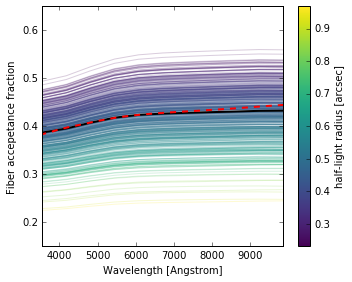

In [48]:
plot_fiberloss_sample(f_elg_sample, ylim=(0.15, 0.65), desimodel_type='ELG',
                      zvalues=elg_sample[1][:, 0], zlabel='half-light radius [arcsec]',
                      save='elg_sample.png')

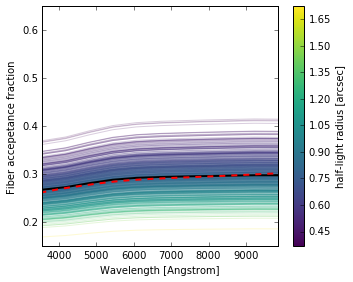

In [49]:
plot_fiberloss_sample(f_lrg_sample, ylim=(0.15, 0.65), desimodel_type='LRG',
                      zvalues=lrg_sample[1][:, 0], zlabel='half-light radius [arcsec]',
                      save='lrg_sample.png')

In [50]:
f_elg_11 = get_fiberloss(*elg_sample, seeing=1.1*u.arcsec, x=focal_x, y=focal_y, desi=desi)

In [51]:
f_elg_13 = get_fiberloss(*elg_sample, seeing=1.3*u.arcsec, x=focal_x, y=focal_y, desi=desi)

In [52]:
f_elg_15 = get_fiberloss(*elg_sample, seeing=1.5*u.arcsec, x=focal_x, y=focal_y, desi=desi)

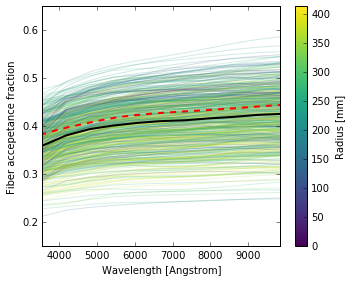

In [53]:
plot_fiberloss(f_elg_11, ylim=(0.15, 0.65), desimodel_type='elg', save='elg_11.png')

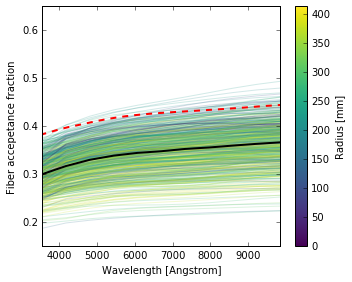

In [54]:
plot_fiberloss(f_elg_13, ylim=(0.15, 0.65), desimodel_type='elg', save='elg_13.png')

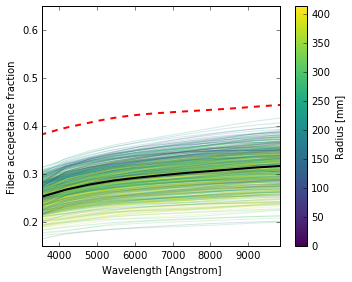

In [55]:
plot_fiberloss(f_elg_15, ylim=(0.15, 0.65), desimodel_type='elg', save='elg_15.png')